# Preprocess Data from Preprocessing file

In [35]:
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/normal_tumor"


# preprocess data
n_samples = 200 # good starting point to train model
seed = 42 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder(sparse_output=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))
train_small_labels = label_encoder.transform(np.array(train_small_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))

Current working directory: /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts
All data have the same shape
Combined data and labels shape: (800, 256, 256, 1), (800,)


# Visually Inspect

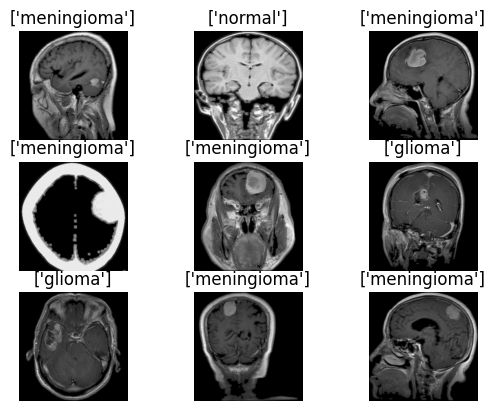

In [14]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

# Modeling
- We first can start with a simple convolution model to see how well a few different architectures will pick up on the training data set,
- Then we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

2024-12-02 15:02:28.699348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Simple CNN to Start

### What is a CNN?
A CNN (convolutional neural network) is a type of network that specializes in processing and predicting grid-like data, making it especially useful for image classification. It utilizes automatic detection of spatial hierarchies and patterns with layers of convolutional filters. Unlike the classic feed-forward network, which connects each neuron to every neuron in the next layer, a CNN uses local receptive fields and shared weights in its convolutional layers, which reduces the number of parameters significantly, and improves the efficiency of the model. 

### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [38]:
# Initialize model
model = Sequential()

# Convolutional layer + pooling
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 1))) # 3x3 is the kernel size, 64 is the number of filters
model.add(MaxPooling2D(2))

# Add another convolutional layer + pooling
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2))

# Add another convolutional layer + pooling
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2))

# Flatten 3D feature maps into 1D feature vectors
model.add(Flatten())

# Fully connected layer
model.add(Dense(units=128, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,857,668 (56.68 MB)

 Trainable params: 14,857,668 (56.68 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2699 - loss: 1.5987 - val_accuracy: 0.3500 - val_loss: 1.3315
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4173 - loss: 1.2824 - val_accuracy: 0.3875 - val_loss: 1.2388
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5044 - loss: 1.1297 - val_accuracy: 0.5312 - val_loss: 1.1400
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6082 - loss: 0.9295 - val_accuracy: 0.7063 - val_loss: 0.8103
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7384 - loss: 0.7097 - val_accuracy: 0.7250 - val_loss: 0.7737
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8348 - loss: 0.5181 - val_accuracy: 0.7063 - val_loss: 0.7714
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8689 - loss: 0.4373 - val_accuracy: 0.7375 - val_loss: 0.6903
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8914 - loss: 0.3402 - val_accuracy: 0.6375 - val_loss:

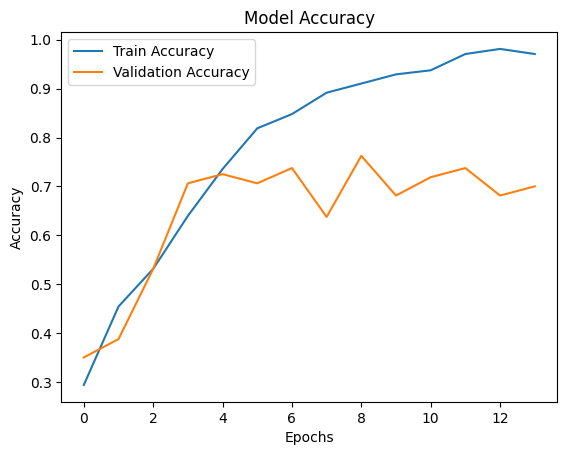

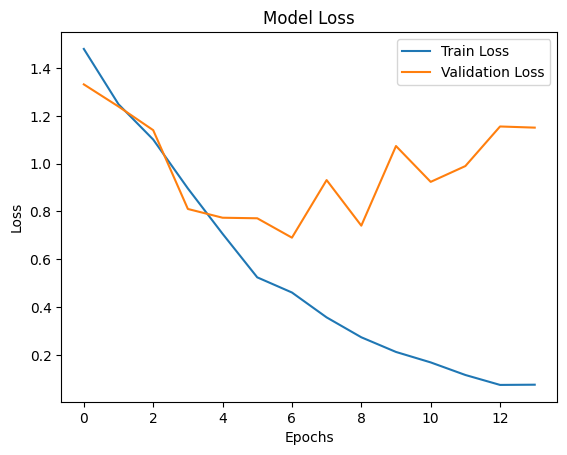

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
# import clear_session to clear the model from memory
from tensorflow.keras import backend as K
K.clear_session()

# Train the model

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_small,
    train_small_labels,
    validation_data=(val_data, val_labels), # Convert sparse matrix
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO LATER once decent performance on simple CNN:
HyperParameter Tuning
- Using Hyperband from kerastuners, we can define a function to build the best model.
- After finding the best model, we can then build a new model to train.

In [2]:
# building a hyperband model to find the best model architecture
import kerastuner as kt
from kerastuner.tuners import Hyperband
def build_model(hp):
    '''Hyperband function to test different model architectures'''
    model = Sequential([
        Conv2D(units=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                     activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D(2), # max pooling to reduce the dimensionality of the data
        Conv2D(units=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
                     activation='relu'),
        MaxPooling2D(2), # max pooling to reduce the dimensionality of the data
        Flatten(), # flatten the data to feed into the dense layers
        Dense(units=hp.Int('dense_1_units', min_value=32, max_value=256, step=32), # find the best number of units
                    activation='relu'),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)), # dropout to prevent overfitting
        Dense(4, activation='softmax') # pituitary, meningioma, glioma, normal
    ])
    # compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), # find the best learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# use cross validation to find the best model
tuner = Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3, directory='my_dir', project_name='intro_to_kt')
tuner.search(train_data, train_labels, epochs=5, validation_data=(val_data, val_labels))
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()